In [1]:
from circle_fit import least_squares_circle as lsc
from src.tools import getFrame, ref_box
from matplotlib import pyplot as plt
from scipy.stats import mode
from os import listdir as L
import numpy as np
import cv2 as C

EDGE_TOL = 400
RADIUS_RANGE = (1, 20)
SCAN_STEP = 8
REGEN_TOL = 0.1
CANNY_STRENGTH = 2.9
videos = L('./data/Kani_1')
VIDEO_FILE = './data/Kani_1/' + videos[0]
print(VIDEO_FILE)

RED = (255, 0, 0)

./data/Kani_1/1_0818_r1_o9_b32.mp4


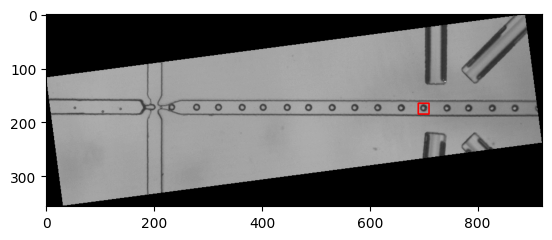

In [2]:
img = getFrame(VIDEO_FILE, 23)

img2 = img.copy()
x0, y0, x1, y1 = ref_box(small=True)

C.rectangle(img2, (y0, x0), (y1, x1), RED, 2)
plt.imshow(img2)
plt.show()

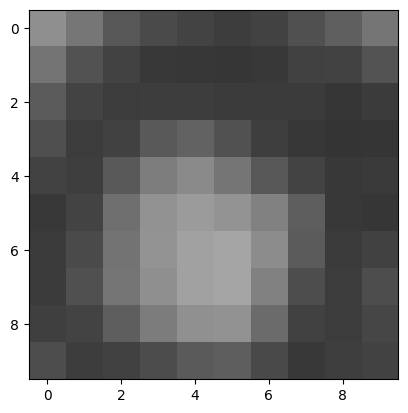

In [3]:
ref = img[x0:x1, y0:y1]

cs = CANNY_STRENGTH*100
edges = C.Canny(ref, cs, cs)
# plt.imshow(edges, cmap='gray')
# plt.show()

cx, cy, R, _ = lsc(np.argwhere(edges > 0))
cx, cy, R = int(cx), int(cy), int(R)

frame = ref[round(cx - R):round(cx + R), round(cy - R):round(cy + R)]
frame_shape = frame.shape
plt.imshow(frame)
plt.savefig('frame.png', bbox_inches='tight')
plt.show()

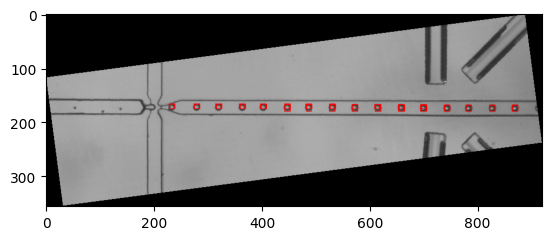

In [4]:
res = C.matchTemplate(img, frame, C.TM_CCOEFF_NORMED)
# for all matches make a rectangle
threshold = 0.68
loc = np.where(res >= threshold)

cxy = []
for pt in zip(*loc[::-1]):
  x, dx = pt[0], frame.shape[1]
  y, dy = pt[1], frame.shape[0]
  y = round(y/R)*R

  cxy.append((round(x+dx/2), round(y+dy/2)))
  C.rectangle(img, pt, (x+dx, y+dy), RED, 1)
cxy = np.array(cxy)

Y = mode(cxy[:, 1]).mode
cxy = cxy[cxy[:, 1] == Y]
diffs = np.diff(cxy[:, 0], 1)
mean = np.mean(diffs)

plt.imshow(img)
plt.show()

In [5]:
print(f"With mean diff of {mean:.2f}R @ R={R}")

With mean diff of 11.12R @ R=5


In [6]:
data_dict = {
  'R': str(R),
  'Y': str(Y),
  'D': str(mean.round(2)),
  'sz': str(frame_shape),
  'f': VIDEO_FILE,
  'bsz': str((y0, x0, y1, x1)),
}

with open('./data.txt', 'w') as f:
  from json import dumps
  f.write(str(dumps(data_dict)))

In [7]:
!rm -rf ./in_dir/* ./out_dir/*

In [8]:
!ffmpeg -hide_banner -loglevel error -i "{VIDEO_FILE}" './in_dir/%03d.png'
!python3 src/extract.py in_dir out_dir {max_Y}
!rm -r ./out_dir/0.png ./out_dir/000.png
!ls ./out_dir | wc -l

Beat frequency: 23 frames
rm: ./out_dir/000.png: No such file or directory
      50
